# Testing stressor metrics from several datasets

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import os
from glob import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from xgboost import XGBRFRegressor
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', 500)


In [2]:
health_df = pd.read_csv("health1.csv")
act_df = pd.read_csv("act1.csv")
sleep_df = pd.read_csv("sleep1.csv")
emot_df = pd.read_csv("emot1.csv")

# Rename 'Unnamed: 0' to 'Date'
health_df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)


In [3]:
health_df

,Date,resting_HR,average_stress,sleeping_hours,Semester,YearSemester,Sick,Weekday,Day Type,Lecturing,Pre-Lecturing
0,2020-07-01,55.0,16.0,7.116667,2,2020 - 2nd,False,2,Weekday,0,NaN
1,2020-07-02,56.0,27.0,6.850000,2,2020 - 2nd,False,3,Weekday,0,NaN
2,2020-07-03,57.0,19.0,6.550000,2,2020 - 2nd,False,4,Weekday,0,NaN
3,2020-07-04,56.0,22.0,6.783333,2,2020 - 2nd,False,5,Weekend,0,NaN
4,2020-07-05,57.0,24.0,8.400000,2,2020 - 2nd,False,6,Weekend,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1365,2024-03-27,58.0,22.0,9.100000,1,2024 - 1st,False,2,Weekday,0,NaN
1366,2024-03-28,58.0,27.0,2.233333,1,2024 - 1st,False,3,Weekday,0,NaN
1367,2024-03-29,59.0,27.0,5.950000,1,2024 - 1st,False,4,Weekday,0,NaN
1368,2024-03-30,60.0,43.0,9.316667,1,2024 - 1st,False,5,Weekend,0,NaN


In [4]:
act_df

,Unnamed: 0.1,Unnamed: 0,VO2,Date,Km,Av_HR_for_Run,run_time,av_cadence
0,0,0,50.0,2024-05-04,10.02580,145.0,59.124067,174.671875
1,1,1,50.0,2024-05-02,8.04976,140.0,49.335650,171.328125
2,2,2,50.0,2024-04-30,5.86950,137.0,35.536633,175.281250
3,3,3,49.0,2024-04-28,6.81160,138.0,42.716883,175.906250
4,4,4,49.0,2024-04-26,9.13527,133.0,58.555600,172.281250
...,...,...,...,...,...,...,...,...
993,993,993,49.0,2020-11-26,9.01783,138.0,57.006750,183.703125
994,994,994,49.0,2020-11-25,13.10173,142.0,80.325300,184.406250
995,995,995,49.0,2020-11-23,4.40349,137.0,26.999217,187.765625
996,996,996,49.0,2020-11-22,11.34087,133.0,74.884784,182.812500


In [5]:
#sleep_df

In [6]:
#emot_df

In [7]:
# Convert 'Date' to datetime and set as index if not already done
health_df['Date'] = pd.to_datetime(health_df['Date'])
health_df.set_index('Date', inplace=True, drop=False)

emot_df['Date'] = pd.to_datetime(emot_df['Date'])
emot_df.set_index('Date', inplace=True, drop=False)

act_df['Date'] = pd.to_datetime(act_df['Date'])
act_df.set_index('Date', inplace=True, drop=False)

sleep_df['calendarDate'] = pd.to_datetime(sleep_df['calendarDate'])
sleep_df.set_index('calendarDate', inplace=True, drop=False)


In [8]:
health_df

,Date,resting_HR,average_stress,sleeping_hours,Semester,YearSemester,Sick,Weekday,Day Type,Lecturing,Pre-Lecturing
Date,,,,,,,,,,,
2020-07-01,2020-07-01,55.0,16.0,7.116667,2,2020 - 2nd,False,2,Weekday,0,NaN
2020-07-02,2020-07-02,56.0,27.0,6.850000,2,2020 - 2nd,False,3,Weekday,0,NaN
2020-07-03,2020-07-03,57.0,19.0,6.550000,2,2020 - 2nd,False,4,Weekday,0,NaN
2020-07-04,2020-07-04,56.0,22.0,6.783333,2,2020 - 2nd,False,5,Weekend,0,NaN
2020-07-05,2020-07-05,57.0,24.0,8.400000,2,2020 - 2nd,False,6,Weekend,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27,2024-03-27,58.0,22.0,9.100000,1,2024 - 1st,False,2,Weekday,0,NaN
2024-03-28,2024-03-28,58.0,27.0,2.233333,1,2024 - 1st,False,3,Weekday,0,NaN
2024-03-29,2024-03-29,59.0,27.0,5.950000,1,2024 - 1st,False,4,Weekday,0,NaN


In [9]:
print(health_df.index.dtype)
print(emot_df.index.dtype)
print(act_df.index.dtype)
print(sleep_df.index.dtype)


datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


In [10]:
# Assuming 'Date' is the index in health_df, create a copy with selected columns
health_selected = health_df[['resting_HR', 'average_stress', 'sleeping_hours', 'Sick', 'Lecturing']].copy()

# Preparing emot_df
emot_df['Date'] = pd.to_datetime(emot_df['Date'])  # Convert 'DateTime' to datetime if needed
emot_selected = emot_df.set_index('Date').copy()
emot_selected = emot_selected[['Moods', 'EmotionCat']]

# Preparing act_df
act_df['Date'] = pd.to_datetime(act_df['Date'])
act_selected = act_df.set_index('Date').copy()
act_selected = act_selected[['Km']]

# Preparing sleep_df if included
sleep_df['calendarDate'] = pd.to_datetime(sleep_df['calendarDate'])
sleep_selected = sleep_df.set_index('calendarDate').copy()
sleep_selected = sleep_selected[['deepSleepSeconds', 'lightSleepSeconds', 'remSleepSeconds', 'awakeSleepSeconds']]


In [11]:
# Merge health_selected with emot_selected
all_df = pd.merge(health_selected, emot_selected, left_index=True, right_index=True, how='outer')

# Merge with act_selected
all_df = pd.merge(all_df, act_selected, left_index=True, right_index=True, how='outer')

# Merge with sleep_selected
all_df = pd.merge(all_df, sleep_selected, left_index=True, right_index=True, how='outer')


In [12]:
all_df

,resting_HR,average_stress,sleeping_hours,Sick,Lecturing,Moods,EmotionCat,Km,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds
2020-06-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2880.0,15600.0,3720.0,660.0
2020-06-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3660.0,16020.0,8100.0,840.0
2020-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3120.0,15180.0,5640.0,1020.0
2020-06-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3120.0,17400.0,7320.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.13527,NaN,NaN,NaN,NaN
2024-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.81160,NaN,NaN,NaN,NaN
2024-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.86950,NaN,NaN,NaN,NaN
2024-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.04976,NaN,NaN,NaN,NaN


In [13]:
# Filter out rows where 'Moods' or 'EmotionCat' is not null
filtered_df = all_df[all_df['Moods'].notna() & all_df['resting_HR'].notna() ]

In [14]:
filtered_df

,resting_HR,average_stress,sleeping_hours,Sick,Lecturing,Moods,EmotionCat,Km,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds
2023-06-05,58.0,26.0,7.783333,False,1.0,Balanced,"Low Energy, Positive",13.07174,7800.0,22740.0,6180.0,600.0
2023-06-05,58.0,26.0,7.783333,False,1.0,Lonely,"Low Energy, Negative",13.07174,7800.0,22740.0,6180.0,600.0
2023-06-05,58.0,26.0,7.783333,False,1.0,Thoughtful,"Low Energy, Positive",13.07174,7800.0,22740.0,6180.0,600.0
2023-06-05,58.0,26.0,7.783333,False,1.0,Pensive,"Low Energy, Positive",13.07174,7800.0,22740.0,6180.0,600.0
2023-06-06,60.0,36.0,6.100000,False,1.0,Excited,"High Energy, Positive",10.69509,2400.0,15840.0,7140.0,360.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-29,59.0,27.0,5.950000,False,0.0,Excited,"High Energy, Positive",NaN,NaN,NaN,NaN,NaN
2024-03-30,60.0,43.0,9.316667,False,0.0,Disengaged,"Low Energy, Negative",5.27848,NaN,NaN,NaN,NaN
2024-03-30,60.0,43.0,9.316667,False,0.0,Vulnerable,"Low Energy, Negative",5.27848,NaN,NaN,NaN,NaN
2024-03-31,59.0,22.0,7.950000,False,0.0,Longing,"Low Energy, Negative",12.11923,NaN,NaN,NaN,NaN


In [15]:
# Encoding categorical variables using get_dummies
filtered_df = pd.get_dummies(filtered_df, columns=['EmotionCat'])
filtered_df = pd.get_dummies(filtered_df, columns=['Moods'])

# Convert binary categorical data to numeric (0 and 1)
filtered_df['Sick'] = filtered_df['Sick'].astype(int)

## Do a random forest for stress levels

In [16]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRFRegressor
import pandas as pd

def run_xgboost_analysis(df, target='average_stress', test_size=0.2, random_state=42, top_features=20, log_scale=False):
    # Prepare the data
    X = df.drop(target, axis=1)
    y = df[target]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Initialize and fit the model
    model = XGBRFRegressor(n_estimators=100, subsample=0.8, colsample_bynode=0.8, max_depth=5, random_state=random_state)
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
    r2 = r2_score(y_test, y_pred)
    
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R² Score: {r2}")
    
    # Feature importances
    feature_importances = model.feature_importances_
    features = pd.Series(feature_importances, index=X_train.columns)
    features_sorted = features.sort_values(ascending=False).head(top_features)  # Only take top 'top_features' features
    
    # Plotting feature importances
    plt.figure(figsize=(12, 8))
    ax = features_sorted.plot(kind='bar', logy=log_scale)
    plt.title('Top Feature Importances in XGBoost Model')
    plt.xlabel('Features')
    plt.ylabel('Importance Score (Log Scale)' if log_scale else 'Importance Score')
    plt.show()

    return model, features_sorted  # Return the model and selected features if needed for further analysis


## Test with all data

Root Mean Squared Error (RMSE): 4.366831597104186
R² Score: 0.5896867991717722


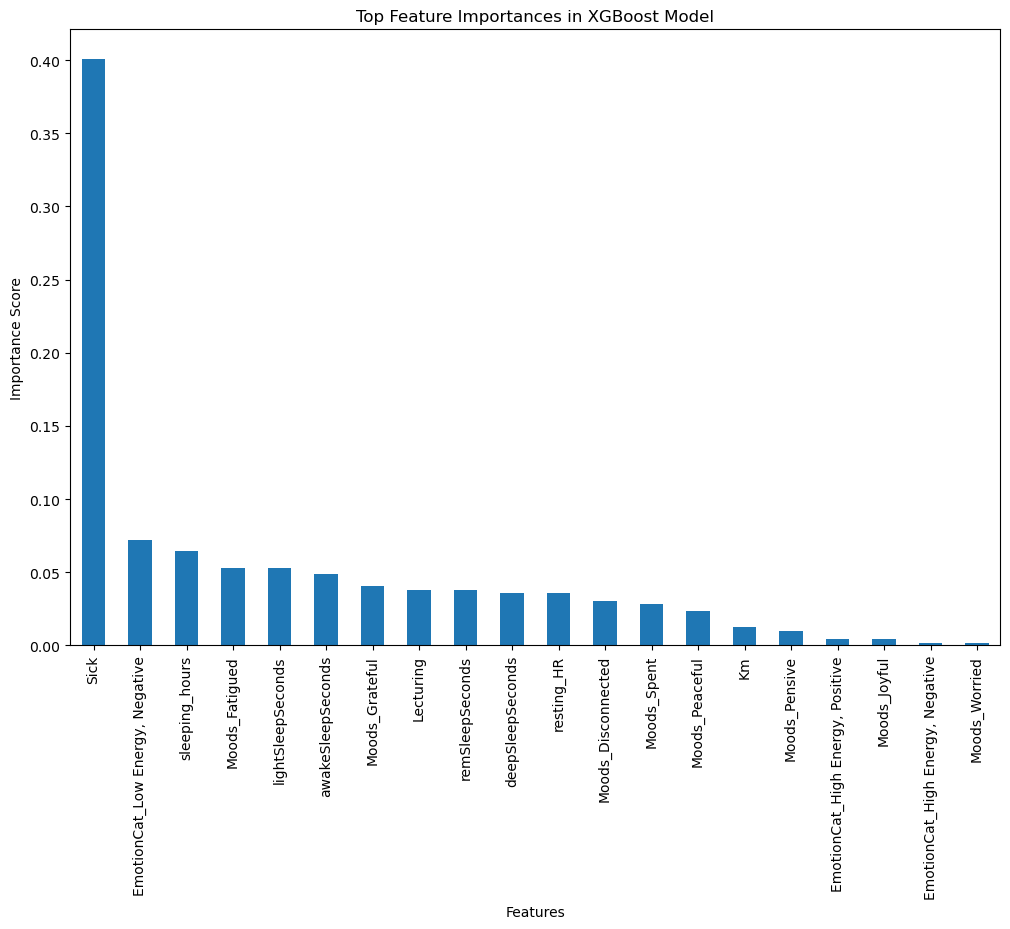

In [17]:
model, features = run_xgboost_analysis(filtered_df)

Root Mean Squared Error (RMSE): 4.366831597104186
R² Score: 0.5896867991717722


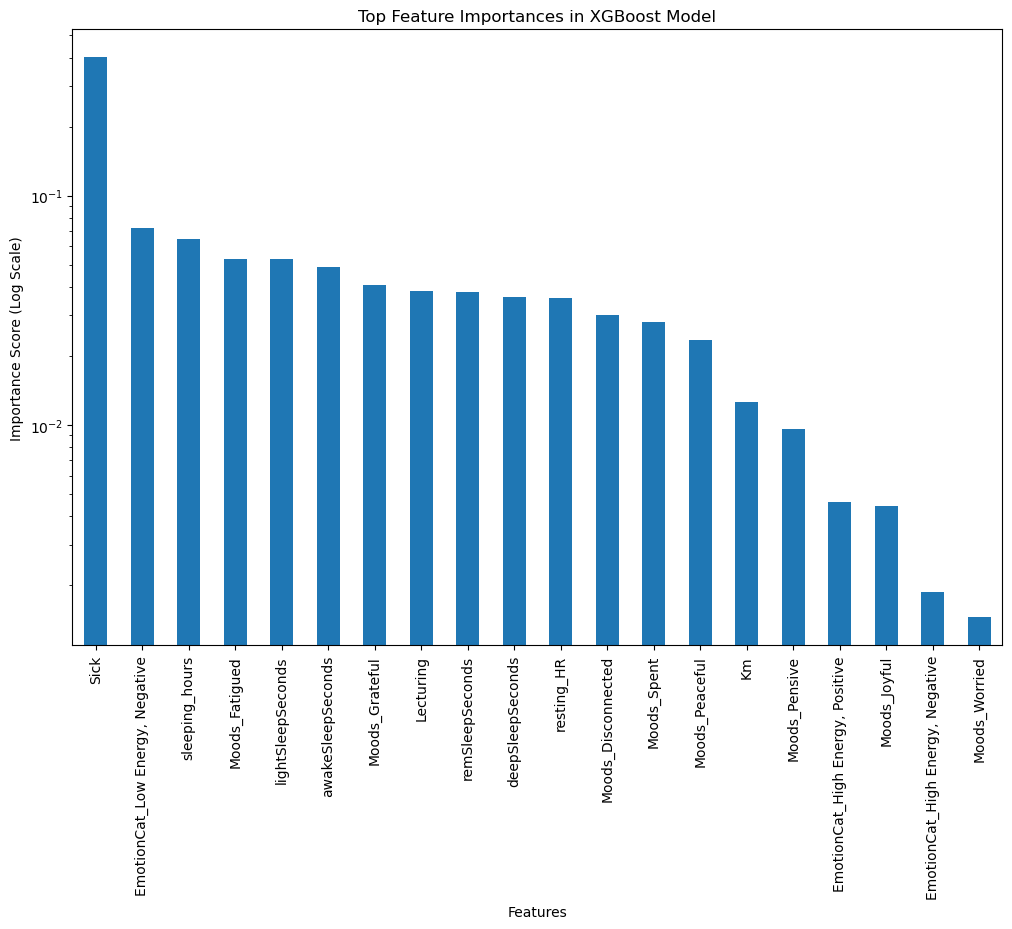

In [18]:
model, features = run_xgboost_analysis(filtered_df, top_features=20, log_scale=True)  # Display top 10 features with log scale

## Test without the sick days, as the sick days also influenced mood with low energy negative and fatigued being in the top

In [19]:
filtered_no_sick = filtered_df[filtered_df["Sick"]!= True]

Root Mean Squared Error (RMSE): 4.159296685942318
R² Score: 0.4519521740162452


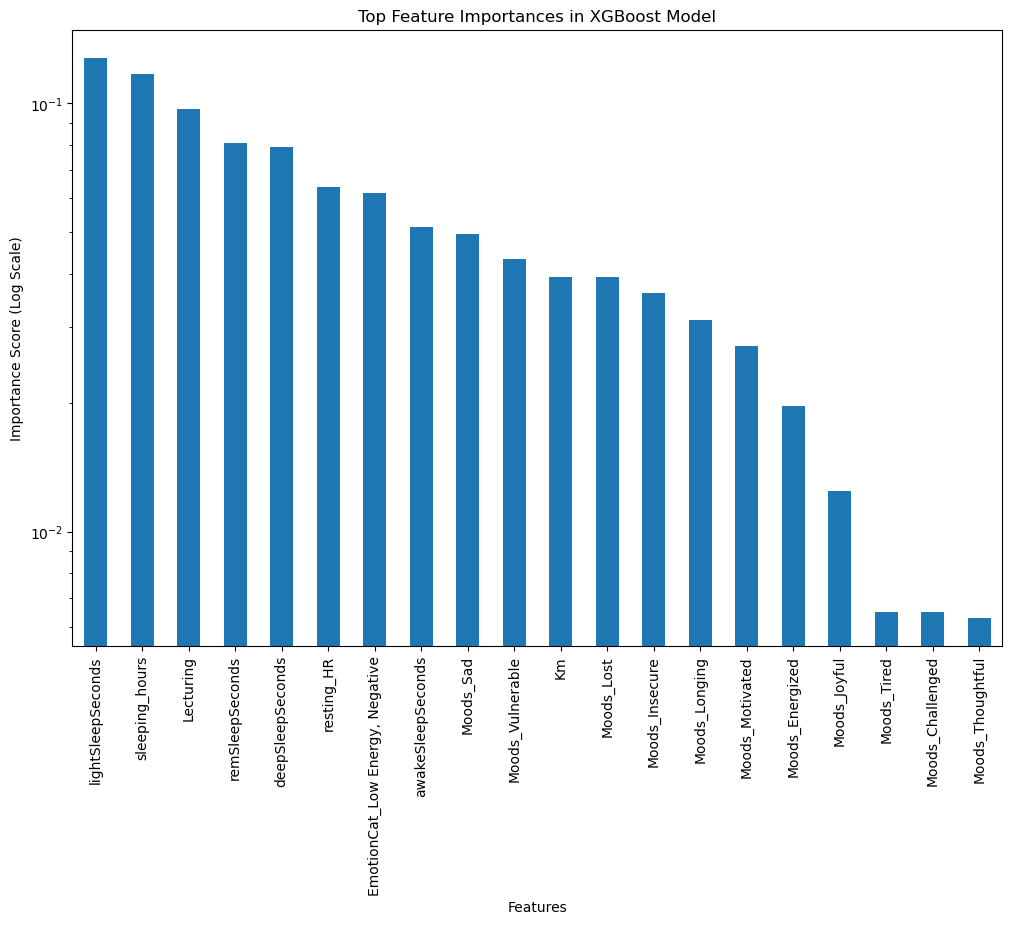

In [20]:
model, features = run_xgboost_analysis(filtered_no_sick, log_scale=True)


## Skip the emotions

In [32]:
# Merge with act_selected
no_emo_df = pd.merge(health_selected, act_selected, left_index=True, right_index=True, how='outer')

# Merge with sleep_selected
no_emo_df = pd.merge(no_emo_df, sleep_selected, left_index=True, right_index=True, how='outer')


In [33]:
no_emo_df

,resting_HR,average_stress,sleeping_hours,Sick,Lecturing,Km,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds
2020-06-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-19,NaN,NaN,NaN,NaN,NaN,NaN,2880.0,15600.0,3720.0,660.0
2020-06-20,NaN,NaN,NaN,NaN,NaN,NaN,3660.0,16020.0,8100.0,840.0
2020-06-21,NaN,NaN,NaN,NaN,NaN,NaN,3120.0,15180.0,5640.0,1020.0
2020-06-22,NaN,NaN,NaN,NaN,NaN,NaN,3120.0,17400.0,7320.0,120.0
...,...,...,...,...,...,...,...,...,...,...
2024-04-26,NaN,NaN,NaN,NaN,NaN,9.13527,NaN,NaN,NaN,NaN
2024-04-28,NaN,NaN,NaN,NaN,NaN,6.81160,NaN,NaN,NaN,NaN
2024-04-30,NaN,NaN,NaN,NaN,NaN,5.86950,NaN,NaN,NaN,NaN
2024-05-02,NaN,NaN,NaN,NaN,NaN,8.04976,NaN,NaN,NaN,NaN


In [34]:
# Check if the DataFrame index is named 'Date', reset the index and name it properly if not already done
if no_emo_df.index.name != 'Date':
    no_emo_df.reset_index(inplace=True)
    no_emo_df.rename(columns={no_emo_df.columns[0]: 'Date'}, inplace=True)  # Ensure the first column is named 'Date'

# Convert 'Date' to datetime type
no_emo_df['Date'] = pd.to_datetime(no_emo_df['Date'])

# Filter out dates before November 21, 2020
no_emo_df = no_emo_df[no_emo_df['Date'] >= '2020-11-21']

# Fill NaN Km values with 0 for the remaining dates
no_emo_df.loc[:, 'Km'] = no_emo_df['Km'].fillna(0)

# Display the first few rows to verify the DataFrame changes
no_emo_df


,Date,resting_HR,average_stress,sleeping_hours,Sick,Lecturing,Km,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds
156,2020-11-21,66.0,26.0,5.550000,False,0.0,12.03584,6000.0,10680.0,3300.0,0.0
157,2020-11-22,63.0,19.0,7.966667,False,0.0,11.34087,4440.0,12960.0,4740.0,360.0
158,2020-11-23,62.0,21.0,7.266667,False,0.0,4.40349,3720.0,19320.0,4560.0,840.0
159,2020-11-24,65.0,23.0,7.016667,False,0.0,0.00000,6360.0,10140.0,4320.0,0.0
160,2020-11-25,61.0,19.0,7.000000,False,0.0,13.10173,4740.0,17820.0,4800.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...
1447,2024-04-26,NaN,NaN,NaN,NaN,NaN,9.13527,NaN,NaN,NaN,NaN
1448,2024-04-28,NaN,NaN,NaN,NaN,NaN,6.81160,NaN,NaN,NaN,NaN
1449,2024-04-30,NaN,NaN,NaN,NaN,NaN,5.86950,NaN,NaN,NaN,NaN
1450,2024-05-02,NaN,NaN,NaN,NaN,NaN,8.04976,NaN,NaN,NaN,NaN


In [35]:
no_emo_df = no_emo_df[no_emo_df['resting_HR'].notna() & no_emo_df['deepSleepSeconds']]

In [36]:
no_emo_df

,Date,resting_HR,average_stress,sleeping_hours,Sick,Lecturing,Km,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds
156,2020-11-21,66.0,26.0,5.550000,False,0.0,12.03584,6000.0,10680.0,3300.0,0.0
157,2020-11-22,63.0,19.0,7.966667,False,0.0,11.34087,4440.0,12960.0,4740.0,360.0
158,2020-11-23,62.0,21.0,7.266667,False,0.0,4.40349,3720.0,19320.0,4560.0,840.0
159,2020-11-24,65.0,23.0,7.016667,False,0.0,0.00000,6360.0,10140.0,4320.0,0.0
160,2020-11-25,61.0,19.0,7.000000,False,0.0,13.10173,4740.0,17820.0,4800.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...
1408,2024-03-10,59.0,29.0,13.583333,False,0.0,4.26230,9780.0,18060.0,5880.0,300.0
1409,2024-03-11,57.0,20.0,8.516667,False,0.0,0.00000,4560.0,22500.0,9420.0,1980.0
1410,2024-03-12,61.0,20.0,6.366667,False,0.0,5.50047,2580.0,17880.0,8160.0,840.0
1411,2024-03-13,56.0,29.0,5.916667,False,0.0,8.00649,5220.0,4680.0,2760.0,240.0


In [37]:
# Drop the 'Date' column if it's not going to be feature engineered
no_emo_df.drop('Date', axis=1, inplace=True)

# Convert boolean 'Sick' column to integer type
no_emo_df['Sick'] = no_emo_df['Sick'].astype(int)

# Check for any other non-numeric columns and convert or handle them
# This is just an example; you'll need to adapt it based on your actual data frame
for col in no_emo_df.select_dtypes(include=['object']).columns:
    no_emo_df[col] = pd.Categorical(no_emo_df[col]).codes  # Convert to category codes if appropriate


/var/folders/l4/00sp3bws4vqggp0ltzbw1_9h0000gn/T/ipykernel_73318/2945686702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_emo_df.drop('Date', axis=1, inplace=True)
/var/folders/l4/00sp3bws4vqggp0ltzbw1_9h0000gn/T/ipykernel_73318/2945686702.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_emo_df['Sick'] = no_emo_df['Sick'].astype(int)


Root Mean Squared Error (RMSE): 5.629414126330118
R² Score: 0.09894115216803478


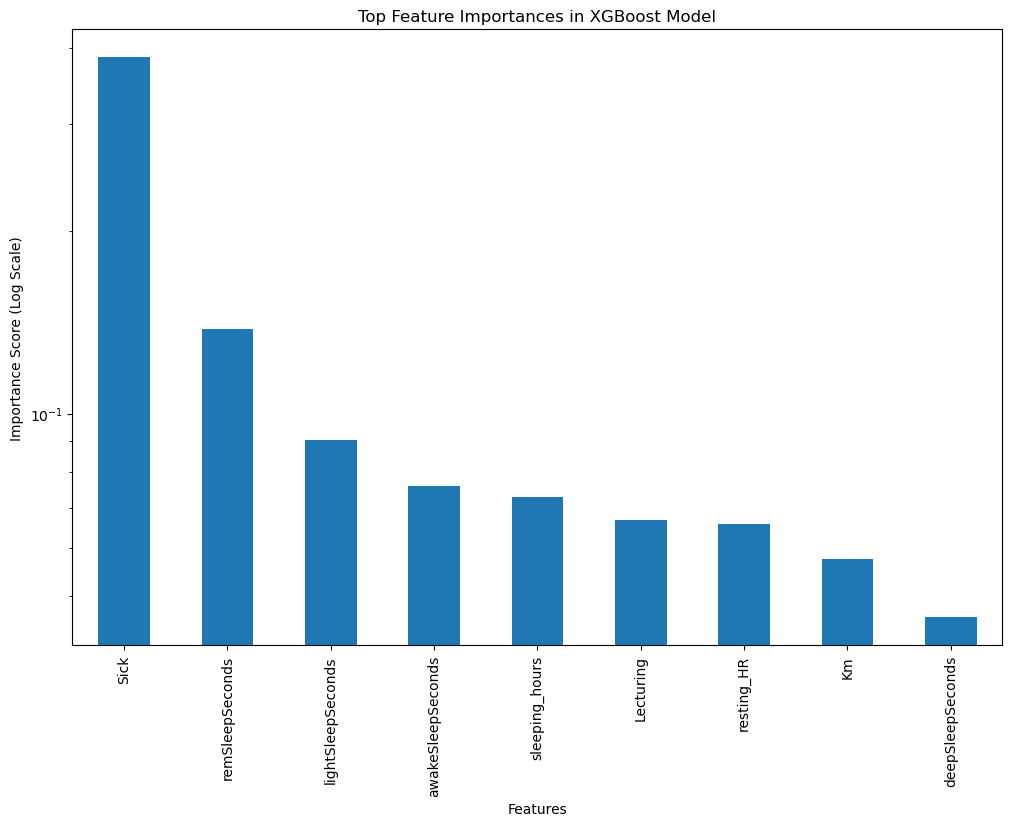

In [42]:
model, features = run_xgboost_analysis(no_emo_df,  log_scale=True)


# Fit model to calculate Shapely Feature importance:

In [63]:
result = no_emo_df

In [64]:
result['ind'] = result.index
result

/var/folders/l4/00sp3bws4vqggp0ltzbw1_9h0000gn/T/ipykernel_73318/88502165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['ind'] = result.index


,resting_HR,average_stress,sleeping_hours,Sick,Lecturing,Km,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds,ind
156,66.0,26.0,5.550000,0,0.0,12.03584,6000.0,10680.0,3300.0,0.0,156
157,63.0,19.0,7.966667,0,0.0,11.34087,4440.0,12960.0,4740.0,360.0,157
158,62.0,21.0,7.266667,0,0.0,4.40349,3720.0,19320.0,4560.0,840.0,158
159,65.0,23.0,7.016667,0,0.0,0.00000,6360.0,10140.0,4320.0,0.0,159
160,61.0,19.0,7.000000,0,0.0,13.10173,4740.0,17820.0,4800.0,60.0,160
...,...,...,...,...,...,...,...,...,...,...,...
1408,59.0,29.0,13.583333,0,0.0,4.26230,9780.0,18060.0,5880.0,300.0,1408
1409,57.0,20.0,8.516667,0,0.0,0.00000,4560.0,22500.0,9420.0,1980.0,1409
1410,61.0,20.0,6.366667,0,0.0,5.50047,2580.0,17880.0,8160.0,840.0,1410
1411,56.0,29.0,5.916667,0,0.0,8.00649,5220.0,4680.0,2760.0,240.0,1411


In [79]:
ml = result.dropna(subset=['average_stress'])
import xgboost as xgb
from sklearn.model_selection import train_test_split

# We want to try to predict the average_stress by given x-parameters using XGBoost algorithm, training on 80% of data
y = ml['average_stress']
X = ml[['resting_HR', 'Km','sleeping_hours','deepSleepSeconds', 'remSleepSeconds', 'awakeSleepSeconds']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)
model = xgb.XGBRegressor()

model.fit(X_train, y_train)
pred = model.predict(X_test)

In [80]:
# Average magnitude of the error in prediction ... about 0.52-0.63 ... 0.55 for seed 42 (random_state)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, pred)

5.097239114404694

[0.1371171  0.14274737 0.16722691 0.15565148 0.21850568 0.17875141]


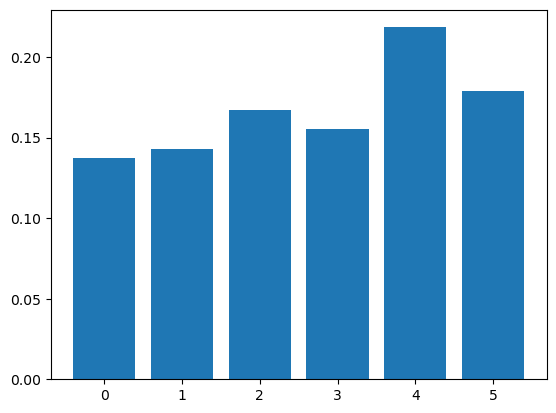

In [81]:
print(model.feature_importances_)
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

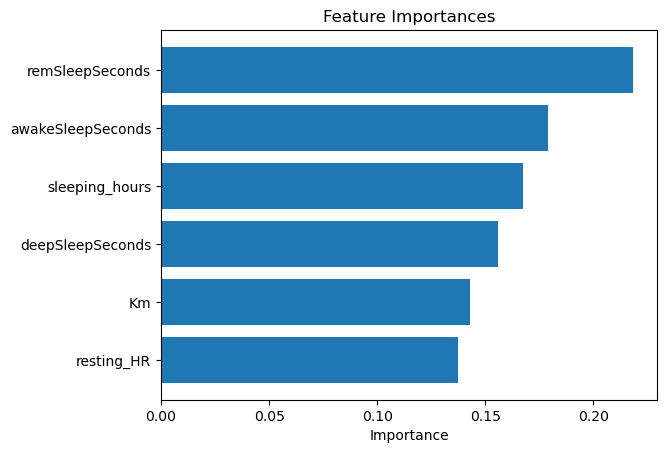

In [82]:
# Assuming your DataFrame X has columns named correctly as per your features:
feature_names = X.columns

# Feature importances from the model
importances = model.feature_importances_

# Sorting importances and corresponding names
sorted_indices = importances.argsort()
sorted_importances = importances[sorted_indices]
sorted_features = feature_names[sorted_indices]

# Creating a bar chart
plt.barh(sorted_features, sorted_importances)  # horizontal bar chart for better readability
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()


In [83]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [84]:
shap.force_plot(explainer.expected_value, shap_values[10], features=X_test.iloc[10], feature_names=X_test.columns)

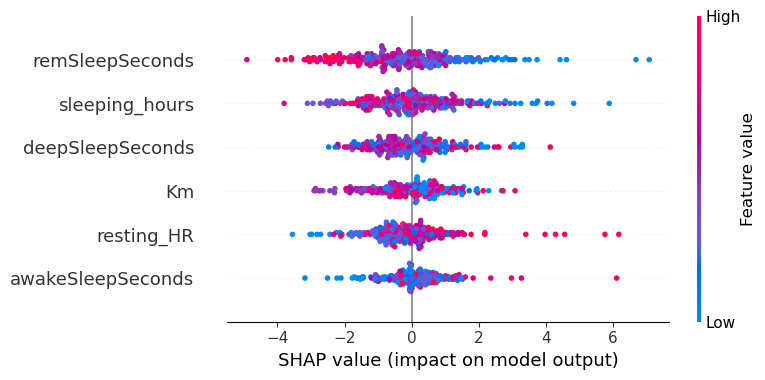

In [85]:
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)

#shap.summary_plot(shap_values, X_train)

## Hmm ... try with emotion categories, see if it makes sense at all

In [96]:
result = filtered_no_sick
result


,resting_HR,average_stress,sleeping_hours,Sick,Lecturing,Km,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds,"EmotionCat_High Energy, Negative","EmotionCat_High Energy, Positive","EmotionCat_Low Energy, Negative","EmotionCat_Low Energy, Positive",Moods_Accepted,Moods_Accomplished,Moods_Alienated,Moods_Alive,Moods_Amused,Moods_Angry,Moods_Annoyed,Moods_Anxious,Moods_Apathetic,Moods_Appreciated,Moods_Ashamed,Moods_At Ease,Moods_Balanced,Moods_Bored,Moods_Burned Out,Moods_Calm,Moods_Carefree,Moods_Challenged,Moods_Cheerful,Moods_Chill,Moods_Comfortable,Moods_Compassionate,Moods_Competent,Moods_Concerned,Moods_Confident,Moods_Confused,Moods_Connected,Moods_Content,Moods_Curious,Moods_Delighted,Moods_Desire,Moods_Determined,Moods_Disappointed,Moods_Disconnected,Moods_Discouraged,Moods_Disengaged,Moods_Down,Moods_Eager,Moods_Ecstatic,Moods_Empathetic,Moods_Empowered,Moods_Empty,Moods_Energized,Moods_Engaged,Moods_Enjoyment,Moods_Enthusiastic,Moods_Envious,Moods_Excited,Moods_Excluded,Moods_Exhausted,Moods_Exhilarated,Moods_Fatigued,Moods_Focused,Moods_Fomo,Moods_Frustrated,Moods_Fulfilled,Moods_Gaslit,Moods_Glum,Moods_Good,Moods_Grateful,Moods_Grumpy,Moods_Happy,Moods_Helpless,Moods_Hopeful,Moods_Inadequate,Moods_Included,Moods_Insecure,Moods_Inspired,Moods_Irritated,Moods_Joyful,Moods_Lonely,Moods_Longing,Moods_Lost,Moods_Loving,Moods_Meh,Moods_Melancholic,Moods_Mellow,Moods_Miserable,Moods_Motivated,Moods_Nervous,Moods_Nostalgic,Moods_Optimistic,Moods_Overwhelmed,Moods_Peaceful,Moods_Pensive,Moods_Pessimistic,Moods_Playful,Moods_Pleasant,Moods_Pleased,Moods_Pressured,Moods_Productive,Moods_Proud,Moods_Regretful,Moods_Rejected,Moods_Relaxed,Moods_Relieved,Moods_Resigned,Moods_Restless,Moods_Sad,Moods_Safe,Moods_Satisfied,Moods_Scared,Moods_Spent,Moods_Successful,Moods_Surprised,Moods_Sympathetic,Moods_Tense,Moods_Thankful,Moods_Thoughtful,Moods_Tired,Moods_Tranquil,Moods_Trapped,Moods_Uncertain,Moods_Understood,Moods_Uneasy,Moods_Upbeat,Moods_Valued,Moods_Vulnerable,Moods_Wishful,Moods_Wistful,Moods_Worried
2023-06-05,58.0,26.0,7.783333,0,1.0,13.07174,7800.0,22740.0,6180.0,600.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2023-06-05,58.0,26.0,7.783333,0,1.0,13.07174,7800.0,22740.0,6180.0,600.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2023-06-05,58.0,26.0,7.783333,0,1.0,13.07174,7800.0,22740.0,6180.0,600.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [104]:
ml = result.dropna(subset=['average_stress'])

# We want to try to predict the average_stress by given x-parameters using XGBoost algorithm, training on 80% of data
y = ml['average_stress']
X = ml[[#'resting_HR', 'Km','sleeping_hours','deepSleepSeconds', 'remSleepSeconds', 'awakeSleepSeconds', 
        'EmotionCat_High Energy, Negative', 'EmotionCat_High Energy, Positive', 
        'EmotionCat_Low Energy, Negative', 'EmotionCat_Low Energy, Positive']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)
model = xgb.XGBRegressor()

model.fit(X_train, y_train)
pred = model.predict(X_test)

In [105]:
# Average magnitude of the error in prediction ... about 0.52-0.63 ... 0.55 for seed 42 (random_state)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, pred)

4.8761295991785385

[1.2563131e-02 2.3447785e-01 8.2391161e-08 7.5295895e-01]


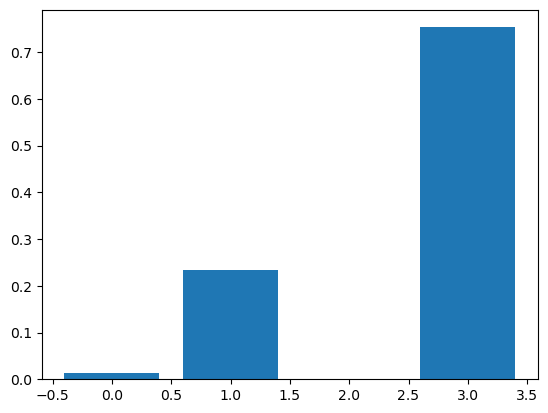

In [106]:
print(model.feature_importances_)
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

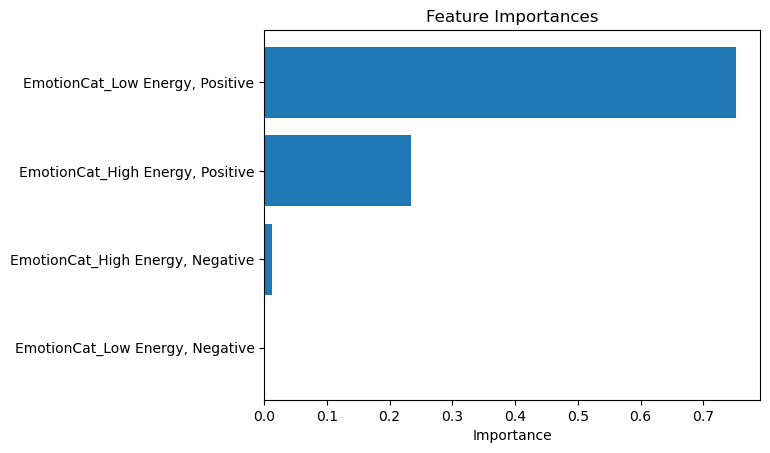

In [107]:
# Assuming your DataFrame X has columns named correctly as per your features:
feature_names = X.columns

# Feature importances from the model
importances = model.feature_importances_

# Sorting importances and corresponding names
sorted_indices = importances.argsort()
sorted_importances = importances[sorted_indices]
sorted_features = feature_names[sorted_indices]

# Creating a bar chart
plt.barh(sorted_features, sorted_importances)  # horizontal bar chart for better readability
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

In [108]:
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [109]:
shap.force_plot(explainer.expected_value, shap_values[10], features=X_test.iloc[10], feature_names=X_test.columns)

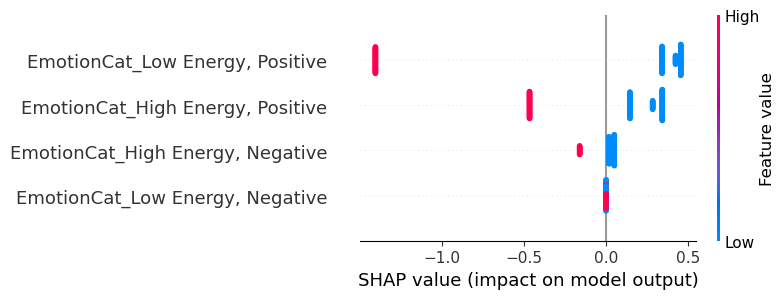

In [110]:
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)

#shap.summary_plot(shap_values, X_train)

### Guess it doesn't really.